In [2]:
# Imports & Global Settings 

import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import seaborn as sns

In [3]:
# Global Plot Settings

plt.rcParams.update({
    'figure.dpi': 200,
    'savefig.dpi': 300,
    'font.size': 7,
    'axes.labelsize': 7,
    'axes.titlesize': 8,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 6,
    'axes.grid': False
})

In [4]:
# Load cleaned data & metadata

df = pd.read_feather("../data/processed/cleaned_nhanes.feather")
with open("../data/processed/metadata.json") as f:
    meta = json.load(f)

cat_features = meta["cat_features"]
num_features = meta["num_features"]
target_cols = meta["target_cols"]

assert df[target_cols].notnull().all().all(), "\u274c Unexpected NaNs in target columns!"

In [5]:
# Reload baseline models 
rf_model = joblib.load("../models/baseline_rf_model.pkl")
linear_model = joblib.load("../models/baseline_linear_model.pkl")

In [6]:
# Train/Test split

X = df.drop(columns=target_cols)
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
# Preprocessing Pipeline 

# Numeric pipeline 
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline 
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine in column transformer 
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

In [8]:
# Define models to compare 

model_defs = {
    "Random Forest": rf_model,
    "Linear Regression": linear_model,
    "Gradient Boosting": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))
    ]),
    "KNN": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(KNeighborsRegressor()))
    ]),
    "Ridge Regression": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(Ridge()))
    ]),
    "SVR": Pipeline([
        ('preprocessing', preprocessor),
        ('regressor', MultiOutputRegressor(SVR()))
    ])
}

In [9]:
# Fit and predict 

results = []

for name, pipeline in model_defs.items():
    print(f"\n🧠 Training {name}...")
    pipeline.fit(X_train, y_train)

    # Predict on both sets
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)

    for i, col in enumerate(target_cols):
        # Train metrics
        r2_train = r2_score(y_train[col], y_pred_train[:, i])
        rmse_train = mean_squared_error(y_train[col], y_pred_train[:, i], squared=False)

        # Test metrics
        r2_test = r2_score(y_test[col], y_pred_test[:, i])
        rmse_test = mean_squared_error(y_test[col], y_pred_test[:, i], squared=False)

        results.extend([
            {"Model": name, "Target": col, "Set": "Train", "R²": r2_train, "RMSE": rmse_train},
            {"Model": name, "Target": col, "Set": "Test", "R²": r2_test, "RMSE": rmse_test},
        ])


🧠 Training Random Forest...

🧠 Training Linear Regression...

🧠 Training Gradient Boosting...

🧠 Training KNN...

🧠 Training Ridge Regression...

🧠 Training SVR...


In [10]:
# Display results (default hyperparameters)

results_df = pd.DataFrame(results)

summary_table = (
    results_df
    .pivot_table(index="Model", 
                 columns=["Set", "Target"], 
                 values=["R²", "RMSE"])
    .round(3)
)

# Flatten column MultiIndex
summary_table.columns = [f"{metric} - {target} ({set_})"
                         for metric, set_, target in summary_table.columns]

# Reorder: group all Train first, then Test
train_cols = [col for col in summary_table.columns if "(Train)" in col]
test_cols = [col for col in summary_table.columns if "(Test)" in col]
summary_table = summary_table[train_cols + test_cols]

# Display
display(summary_table)


,RMSE - a1c (Train),RMSE - hdl_cholesterol (Train),RMSE - vitamin_d (Train),R² - a1c (Train),R² - hdl_cholesterol (Train),R² - vitamin_d (Train),RMSE - a1c (Test),RMSE - hdl_cholesterol (Test),RMSE - vitamin_d (Test),R² - a1c (Test),R² - hdl_cholesterol (Test),R² - vitamin_d (Test)
Model,,,,,,,,,,,,
Gradient Boosting,0.754,12.210,18.759,0.472,0.414,0.403,0.984,14.180,22.023,0.134,0.247,0.191
KNN,0.855,12.542,19.355,0.321,0.381,0.364,1.056,15.786,23.799,0.003,0.066,0.055
Linear Regression,0.932,14.045,21.341,0.194,0.224,0.227,0.960,14.537,21.240,0.176,0.208,0.248
Random Forest,0.360,5.354,8.277,0.880,0.887,0.884,0.975,14.330,21.794,0.150,0.231,0.208
Ridge Regression,0.931,13.994,21.231,0.196,0.230,0.235,0.958,14.498,21.178,0.180,0.213,0.252
SVR,0.891,14.121,22.104,0.263,0.216,0.171,0.977,14.533,22.282,0.146,0.209,0.172


In [11]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [12]:
# Random Forest Regressor Hyperparameter Tuning

rf_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(RandomForestRegressor(random_state=42)))
])

param_grid_rf = {
    'regressor__estimator__n_estimators': [100, 200],
    'regressor__estimator__max_depth': [None, 10, 20],
    'regressor__estimator__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    rf_pipeline, param_grid_rf, cv=cv, scoring='r2', n_jobs=-1, verbose=1
)
grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [13]:
# Gradient Boosting Regressor Hyperparameter Tuning

gbr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(GradientBoostingRegressor(random_state=42)))
])

param_grid_gbr = {
    'regressor__estimator__n_estimators': [100, 300],
    'regressor__estimator__learning_rate': [0.05, 0.1],
    'regressor__estimator__max_depth': [3, 5]
}

grid_gbr = GridSearchCV(
    gbr_pipeline, param_grid_gbr, cv=cv, scoring='r2', n_jobs=-1, verbose=1
)
grid_gbr.fit(X_train, y_train)
best_gbr = grid_gbr.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [14]:
# K-Nearest Neighbors Regressor Hyperparameter Tuning

knn_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(KNeighborsRegressor()))
])

param_grid_knn = {
    'regressor__estimator__n_neighbors': [3, 5, 7],
    'regressor__estimator__weights': ['uniform', 'distance']
}

grid_knn = GridSearchCV(
    knn_pipeline, param_grid_knn, cv=cv, scoring='r2', n_jobs=-1, verbose=1
)
grid_knn.fit(X_train, y_train)
best_knn = grid_knn.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [15]:
# Support Vector Regressor Hyperparameter Tuning

svr_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(SVR()))
])

param_grid_svr = {
    'regressor__estimator__C': [1.0, 10.0],
    'regressor__estimator__epsilon': [0.1, 0.5],
    'regressor__estimator__kernel': ['rbf', 'linear']
}

grid_svr = GridSearchCV(
    svr_pipeline, param_grid_svr, cv=cv, scoring='r2', n_jobs=-1, verbose=1
)
grid_svr.fit(X_train, y_train)
best_svr = grid_svr.best_estimator_

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [16]:
# Ridge Regression Hyperparameter Tuning

ridge_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('regressor', MultiOutputRegressor(Ridge()))
])

param_grid_ridge = {
    'regressor__estimator__alpha': [0.1, 1.0, 10.0, 100.0]
}

grid_ridge = GridSearchCV(
    ridge_pipeline, param_grid_ridge, 
    cv=cv, scoring='r2', n_jobs=-1, verbose=1
)
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [17]:
# Create comparison dictionary 

final_models = {
    "Baseline: Random Forest": rf_model,
    "Baseline: Linear Regression": linear_model,
    "Tuned: Random Forest": best_rf,
    "Tuned: Gradient Boosting": best_gbr,
    "Tuned: KNN": best_knn,
    "Tuned: Ridge": best_ridge,
    "Tuned: SVR": best_svr
}

In [18]:
# Evaluate each model (with test data)

comparison_results = []

for name, model in final_models.items():
    y_pred = model.predict(X_test)

    for i, col in enumerate(target_cols):
        r2 = r2_score(y_test[col], y_pred[:, i])
        rmse = mean_squared_error(y_test[col], y_pred[:, i], squared=False)

        comparison_results.append({
            "Model": name,
            "Target": col,
            "R²": r2,
            "RMSE": rmse
        })

In [19]:
# Convert to DataFrame 

compare_df = pd.DataFrame(comparison_results)

In [20]:
# Pivot to summary table

summary_table = (
    compare_df
    .pivot(index="Model", columns="Target", values=["R²", "RMSE"])
    .round(3)
)

# Flatten MultiIndex for readability
summary_table.columns = [f"{metric} - {target}" for metric, target in summary_table.columns]

# Sort rows by overall average R²
summary_table["Avg R²"] = compare_df.groupby("Model")["R²"].mean().round(3)
summary_table = summary_table.sort_values(by="Avg R²", ascending=False)
summary_table = summary_table.drop(columns="Avg R²")

# Display 
display(summary_table)


,R² - a1c,R² - hdl_cholesterol,R² - vitamin_d,RMSE - a1c,RMSE - hdl_cholesterol,RMSE - vitamin_d
Model,,,,,,
Tuned: Ridge,0.184,0.216,0.250,0.955,14.462,21.214
Tuned: Gradient Boosting,0.160,0.255,0.224,0.969,14.101,21.567
Baseline: Linear Regression,0.176,0.208,0.248,0.960,14.537,21.240
Tuned: Random Forest,0.160,0.249,0.226,0.970,14.158,21.548
Tuned: SVR,0.166,0.207,0.240,0.966,14.550,21.355
Baseline: Random Forest,0.150,0.231,0.208,0.975,14.330,21.794
Tuned: KNN,0.072,0.081,0.098,1.019,15.665,23.256


/var/folders/24/g37df8wx6_x56rglyfz1k1zw0000gn/T/ipykernel_24542/2101355124.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r2_long["Model"] = pd.Categorical(r2_long["Model"], categories=model_order, ordered=True)
/var/folders/24/g37df8wx6_x56rglyfz1k1zw0000gn/T/ipykernel_24542/2101355124.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rmse_long["Model"] = pd.Categorical(rmse_long["Model"], categories=model_order, ordered=True)
/var/folders/24/g37df8wx6_x56rglyfz1k1zw0000gn/T/ipykernel_24542/21013

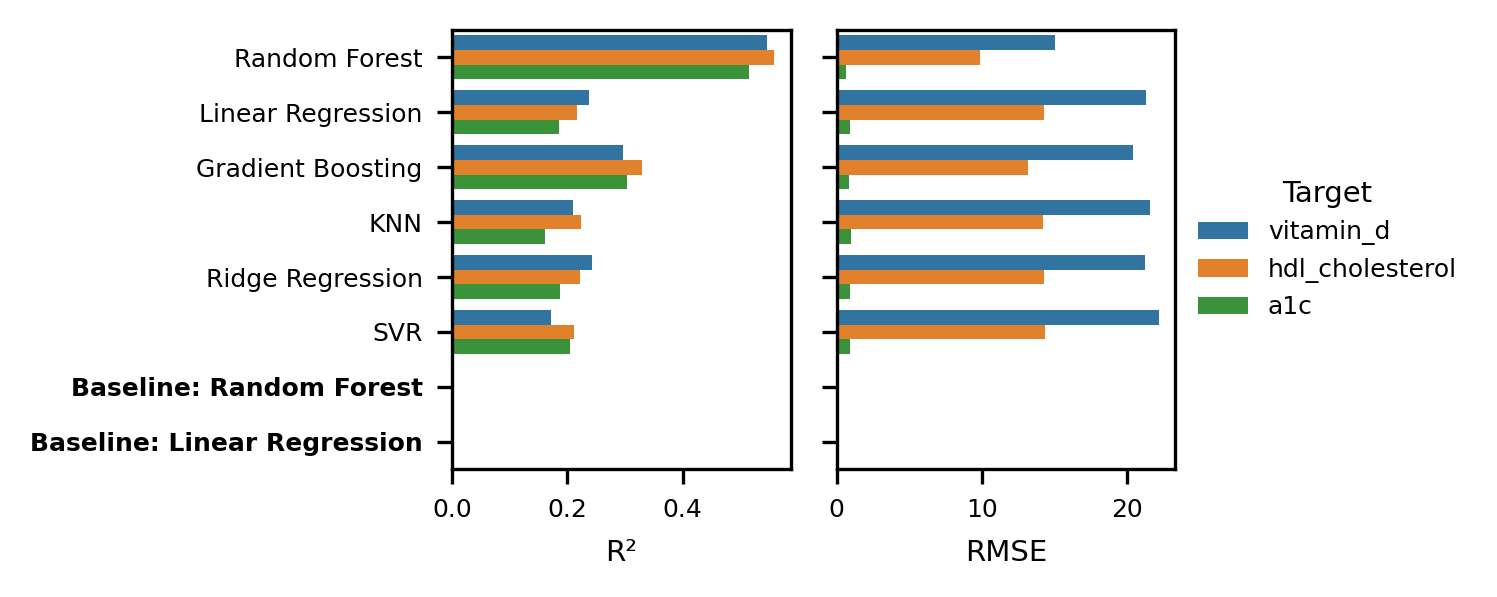

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Subset and prep long format
r2_long = results_df[["Model", "Target", "R²"]]
rmse_long = results_df[["Model", "Target", "RMSE"]]

# Define baseline model names exactly as used
baseline_models = ["Baseline: Random Forest", "Baseline: Linear Regression"]
non_baseline_models = [m for m in r2_long["Model"].unique() if m not in baseline_models]
model_order = non_baseline_models + baseline_models  # Baselines go at the bottom

# Apply ordering
r2_long["Model"] = pd.Categorical(r2_long["Model"], categories=model_order, ordered=True)
rmse_long["Model"] = pd.Categorical(rmse_long["Model"], categories=model_order, ordered=True)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(5, 2), dpi=300, sharey=True)

# R² plot
sns.barplot(data=r2_long, x="R²", y="Model", hue="Target", ax=axes[0], ci=None)
axes[0].tick_params(labelsize=6)
axes[0].set_xlabel("R²", fontsize=7)
axes[0].set_ylabel("")
axes[0].legend_.remove()

# Bold baseline model tick labels
for tick_label in axes[0].get_yticklabels():
    if tick_label.get_text() in baseline_models:
        tick_label.set_fontweight("bold")

# RMSE plot
sns.barplot(data=rmse_long, x="RMSE", y="Model", hue="Target", ax=axes[1], ci=None)
axes[1].legend(
    title="Target",
    fontsize=6,
    title_fontsize=7,
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    frameon=False
)
axes[1].tick_params(labelsize=6)
axes[1].set_xlabel("RMSE", fontsize=7)
axes[1].set_ylabel("")

# Bold baseline model tick labels
for tick_label in axes[1].get_yticklabels():
    if tick_label.get_text() in baseline_models:
        tick_label.set_fontweight("bold")

plt.tight_layout()
plt.show()


In [22]:
print(results_df["Model"].unique())


['Random Forest' 'Linear Regression' 'Gradient Boosting' 'KNN'
 'Ridge Regression' 'SVR']


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Organize models
best_models = {
    "Random Forest": best_rf,
    "Gradient Boosting": best_gbr,
    "KNN": best_knn,
    "SVR": best_svr,
    "Ridge": best_ridge,
}

# Define CV strategies
cv_strategies = {
    "5-Fold": KFold(n_splits=5, shuffle=True, random_state=42),
    "10-Fold": KFold(n_splits=10, shuffle=True, random_state=42),
    "20-Fold": KFold(n_splits=20, shuffle=True, random_state=42),
    "40-Fold": KFold(n_splits=40, shuffle=True, random_state=42)
}

# Collect results
results = []

for model_name, model in best_models.items():
    for cv_name, cv in cv_strategies.items():
        r2_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
        rmse_scores = -cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
        results.append({
            "Model": model_name,
            "CV": cv_name,
            "R2 Mean": np.mean(r2_scores),
            "R2 Std": np.std(r2_scores),
            "RMSE Mean": np.mean(rmse_scores),
            "RMSE Std": np.std(rmse_scores),
        })

# Convert to dataframe
results_df = pd.DataFrame(results)
display(results_df)

# Plot cv evolution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# R² plot
for model in results_df['Model'].unique():
    subset = results_df[results_df['Model'] == model]
    ax[0].errorbar(subset['CV'], subset['R2 Mean'], yerr=subset['R2 Std'], label=model, capsize=3, marker='o')
ax[0].set_title('R² by Model and CV', fontsize=16)
ax[0].set_ylabel('R²', fontsize=14)
ax[0].set_xlabel('CV Strategy', fontsize=14)
ax[0].tick_params(axis='both', labelsize=12)
ax[0].legend(fontsize=12)

# RMSE plot
for model in results_df['Model'].unique():
    subset = results_df[results_df['Model'] == model]
    ax[1].errorbar(subset['CV'], subset['RMSE Mean'], yerr=subset['RMSE Std'], label=model, capsize=3, marker='o')
ax[1].set_title('RMSE by Model and CV', fontsize=16)
ax[1].set_ylabel('RMSE', fontsize=14)
ax[1].set_xlabel('CV Strategy', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()
